In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime,timedelta

<p>Task 1: To estimate the average travel time from designated intersections to tollgates
For every 20-minute time window, please estimate the average travel time of vehicles for a specific route (shown in Figure 1). </p>

  <ul> 
      <li> a. Routes from Intersection A to Tollgates 2 & 3; </li> 
      <li> b. Routes from Intersection B to Tollgates 1 & 3; </li>
      <li> c. Routes from Intersection C to Tollages 1 & 3. </li>
  </ul>

<p>Note: the ETA of a 20-minute time window for a given route is the average travel time of all vehicle trajectories that enter the route in that time window. Each 20-minute time window is defined as a right half-open interval, e.g., [2016-09-18 23:40:00, 2016-09-19 00:00:00). </p>

<img src="../data/dataSets/training/Figure_1.png" alt="Figure 1. Road Network Topology of the Target Area" width="500" height="300">

In [2]:
#define the constants used in the file
file_suffix = '.csv'
train_path = '../data/dataSets/training/'
test_path = '../data/dataSets/testing_phase1/'

<h2> Understand Traffic Data </h2>

In [8]:
#traffic Data 
trajectories = pd.read_csv(train_path + 'trajectories(table 5)_training.csv') 
trajectories.head()

,intersection_id,tollgate_id,vehicle_id,starting_time,travel_seq,travel_time
0,B,3,1065642,2016-07-19 00:14:00,105#2016-07-19 00:14:24#9.56;100#2016-07-19 00...,70.85
1,B,3,1047198,2016-07-19 00:35:00,105#2016-07-19 00:35:56#11.58;100#2016-07-19 0...,148.79
2,B,1,1086390,2016-07-19 00:37:00,105#2016-07-19 00:37:15#5.26;100#2016-07-19 00...,79.76
3,A,2,1071181,2016-07-19 00:37:00,110#2016-07-19 00:37:59#13.74;123#2016-07-19 0...,58.05
4,B,1,1065807,2016-07-19 00:56:00,105#2016-07-19 00:56:21#16.08;100#2016-07-19 0...,137.98


In [13]:
#With reference to https://github.com/ttff96989/KDD-CUP-2017/blob/master/scripts/aggregate_travel_time.py
#the script is provided by KDD Cup 2017 Organising Committee 
def avgTravelTime(in_file,path):

    out_suffix = '_20min_avg_travel_time'
    in_file_name = in_file + file_suffix
    out_file_name = in_file.split('_')[1] + out_suffix + file_suffix
    path = path

    # Step 1: Load trajectories
    fr = open(path + in_file_name, 'r')
    fr.readline()  # skip the header
    traj_data = fr.readlines()
    fr.close()
    print(traj_data[0])

    # Step 2: Create a dictionary to store travel time for each route per time window
    travel_times = {}  # key: route_id. Value is also a dictionary of which key is the start time for the time window and value is a list of travel times
    for i in range(len(traj_data)):
        each_traj = traj_data[i].replace('"', '').split(',')
        intersection_id = each_traj[0]
        tollgate_id = each_traj[1]

        route_id = intersection_id + '-' + tollgate_id
        if route_id not in travel_times.keys():
            travel_times[route_id] = {}

        trace_start_time = each_traj[3]
        trace_start_time = datetime.strptime(trace_start_time, "%Y-%m-%d %H:%M:%S")
        time_window_minute = math.floor(trace_start_time.minute / 20) * 20
        start_time_window = datetime(trace_start_time.year, trace_start_time.month, trace_start_time.day,
                                     trace_start_time.hour, time_window_minute, 0)
        tt = float(each_traj[-1]) # travel time
        
        
        #Ignore national holiday due to abnornmally high traffic (outliers)
        
        time=start_time_window
        tt = float(each_traj[-1])
        
        if(time.month==10 and time.day in [1,2,3,4,5,6,7]):
            continue
        
        if(time.month==9 and time.day in [15,16,17]):
            continue

        if start_time_window not in travel_times[route_id].keys():
            travel_times[route_id][start_time_window] = [tt]
        else:
            travel_times[route_id][start_time_window].append(tt)

    # Step 3: Calculate average travel time for each route per time window
    fw = open(out_file_name, 'w')
    fw.writelines(','.join(['"intersection_id"', '"tollgate_id"', '"time_window"', '"avg_travel_time"']) + '\n')
    for route in travel_times.keys():
        route_time_windows = list(travel_times[route].keys())
        route_time_windows.sort()
        for time_window_start in route_time_windows:
            time_window_end = time_window_start + timedelta(minutes=20)
            tt_set = travel_times[route][time_window_start]
            avg_tt = round(sum(tt_set) / float(len(tt_set)), 2)
            out_line = ','.join(['"' + route.split('-')[0] + '"', '"' + route.split('-')[1] + '"',
                                 '"[' + str(time_window_start) + ',' + str(time_window_end) + ')"',
                                 '"' + str(avg_tt) + '"']) + '\n'
            fw.writelines(out_line)
    fw.close()

In [14]:
filename = 'trajectories(table 5)_training'
avgTravelTime(filename, train_path)

B,3,1065642,2016-07-19 00:14:00,105#2016-07-19 00:14:24#9.56;100#2016-07-19 00:14:34#6.75;111#2016-07-19 00:14:41#13.00;103#2016-07-19 00:14:54#7.47;122#2016-07-19 00:15:02#32.85,70.85



In [15]:
df = pd.read_csv('training_20min_avg_travel_time.csv')
df.shape

(21803, 4)

In [16]:
df.head() # Start date/time of training data set

,intersection_id,tollgate_id,time_window,avg_travel_time
0,B,3,"[2016-07-19 00:00:00,2016-07-19 00:20:00)",70.85
1,B,3,"[2016-07-19 00:20:00,2016-07-19 00:40:00)",148.79
2,B,3,"[2016-07-19 01:40:00,2016-07-19 02:00:00)",93.72
3,B,3,"[2016-07-19 02:00:00,2016-07-19 02:20:00)",67.81
4,B,3,"[2016-07-19 02:40:00,2016-07-19 03:00:00)",167.55


In [17]:
df.tail() # End date/time of training data set

,intersection_id,tollgate_id,time_window,avg_travel_time
21798,C,1,"[2016-10-17 20:40:00,2016-10-17 21:00:00)",171.97
21799,C,1,"[2016-10-17 21:20:00,2016-10-17 21:40:00)",121.61
21800,C,1,"[2016-10-17 22:20:00,2016-10-17 22:40:00)",115.16
21801,C,1,"[2016-10-17 23:00:00,2016-10-17 23:20:00)",194.33
21802,C,1,"[2016-10-17 23:20:00,2016-10-17 23:40:00)",159.78


<h4> Understand Average Travelling Speed </h4>

In [18]:
A_2_direction = df[df['intersection_id'] == 'A'][df['tollgate_id'] == 2]
A_3_direction = df[df['intersection_id'] == 'A'][df['tollgate_id'] == 3]
B_1_direction = df[df['intersection_id'] == 'B'][df['tollgate_id'] == 1]
B_3_direction = df[df['intersection_id'] == 'B'][df['tollgate_id'] == 3]
C_1_direction = df[df['intersection_id'] == 'C'][df['tollgate_id'] == 1]
C_3_direction = df[df['intersection_id'] == 'C'][df['tollgate_id'] == 3]

C:\Users\meiro\.conda\envs\issmv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\meiro\.conda\envs\issmv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\meiro\.conda\envs\issmv\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\meiro\.conda\envs\issmv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\meiro\.conda\envs\issmv\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\meiro\.conda\envs\issmv\lib\site-packages\ipykerne

In [19]:
A_2_direction.head()
A_3_direction.head()
B_1_direction.head()
B_3_direction.head()
C_1_direction.head()
C_3_direction.head()

,intersection_id,tollgate_id,time_window,avg_travel_time
12191,C,3,"[2016-07-19 00:40:00,2016-07-19 01:00:00)",113.54
12192,C,3,"[2016-07-19 06:20:00,2016-07-19 06:40:00)",161.74
12193,C,3,"[2016-07-19 06:40:00,2016-07-19 07:00:00)",223.81
12194,C,3,"[2016-07-19 07:00:00,2016-07-19 07:20:00)",135.92
12195,C,3,"[2016-07-19 07:20:00,2016-07-19 07:40:00)",236.12


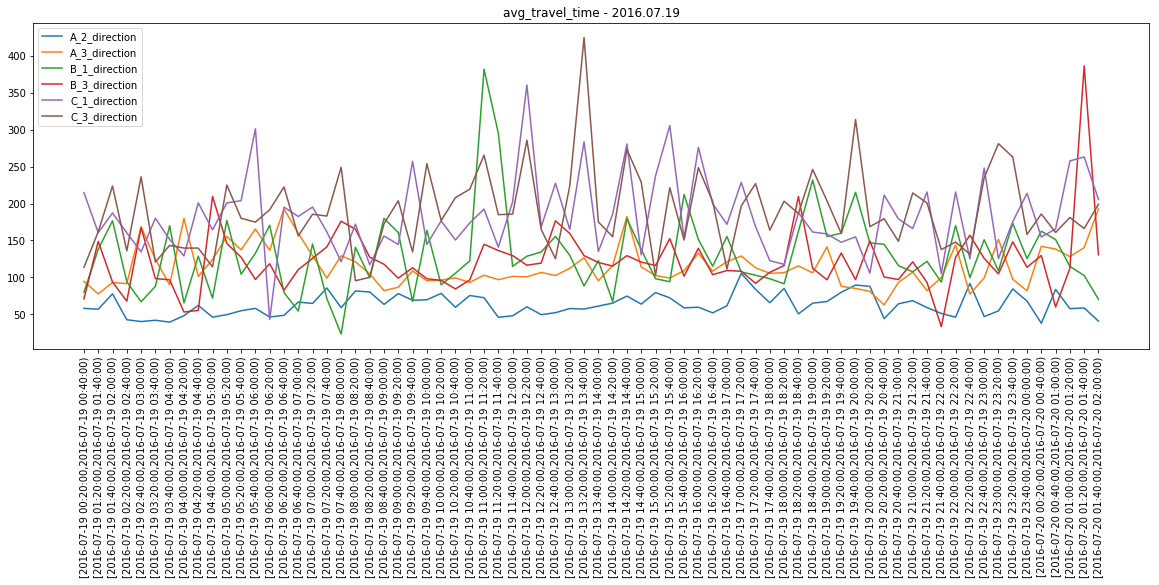

In [70]:
# Vosualize data pattern
plt.figure(figsize=(20,6))

xticks = A_2_direction['time_window'].values
plt.plot(xticks[:72], A_2_direction['avg_travel_time'][:72], label='A_2_direction')
plt.plot(xticks[:72], A_3_direction['avg_travel_time'][:72], label='A_3_direction')
plt.plot(xticks[:72], B_1_direction['avg_travel_time'][:72], label='B_1_direction')
plt.plot(xticks[:72], B_3_direction['avg_travel_time'][:72], label='B_3_direction')
plt.plot(xticks[:72], C_1_direction['avg_travel_time'][:72], label='C_1_direction')
plt.plot(xticks[:72], C_3_direction['avg_travel_time'][:72], label='C_3_direction')
plt.xticks(xticks[:72], xticks[:72], rotation='vertical')
plt.title('avg_travel_time - 2016.07.19')
plt.legend()
plt.show()

<p> Generally, it takes longer time to travel from Junction C to Tollgate 3 </p>